In [1]:
import json
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm

from analysis_utils import get_test_results_all_tasks, target_testsuites, load_input_hidden_states

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np
import torch
import random

import time
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scienceplots

plt.style.use(["science", "grid", "nature"])

plt.rcParams.update({
    "font.size": 12,           
    "axes.titlesize": 14,      
    "axes.labelsize": 12,      
    "xtick.labelsize": 10,     
    "ytick.labelsize": 10,     
    "legend.fontsize": 10,     
})

tasks = list(target_testsuites.keys())
print('Prompting Tasks:', tasks)

model='llama'

inference_results, labels, test_scores = get_test_results_all_tasks(model=model)

Prompting Tasks: ['syntactic_bug_detection', 'spell_check', 'github_typo_check', 'json_repair', 'pos_detection', 'topic_classification', 'adding_odd_numbers', 'model_name_extraction']


Processing datasets: 100%|██████████| 8/8 [00:14<00:00,  1.85s/it]


In [2]:
target_tasks = ['spell_check', 'syntactic_bug_detection']
target_layers = [1, 6, 11, 16, 21, 26, 31]

df_vis = {}
for i, target_task in enumerate(tqdm(target_tasks, desc='tasks')):
    for j, target_layer in enumerate(tqdm(target_layers, desc='layers')):
        hidden_states = load_input_hidden_states(target_task, target_layer, model=model)

        pca = PCA(n_components=10)
        data_pca = pca.fit_transform(hidden_states)

        tsne = TSNE(n_components=2, random_state=42)
        data_tsne = tsne.fit_transform(data_pca)

        del hidden_states, tsne, data_pca
        gc.collect()

        df_vis[(target_task, target_layer)] = pd.DataFrame(data_tsne, columns=["Component 1", "Component 2"])
        df_vis[(target_task, target_layer)]["Test Score"] = test_scores[target_task]
        
        del data_tsne
        gc.collect()


tasks: 100%|██████████| 2/2 [07:41<00:00, 230.88s/it]


tasks: 100%|██████████| 2/2 [00:00<00:00, 68.45it/s]


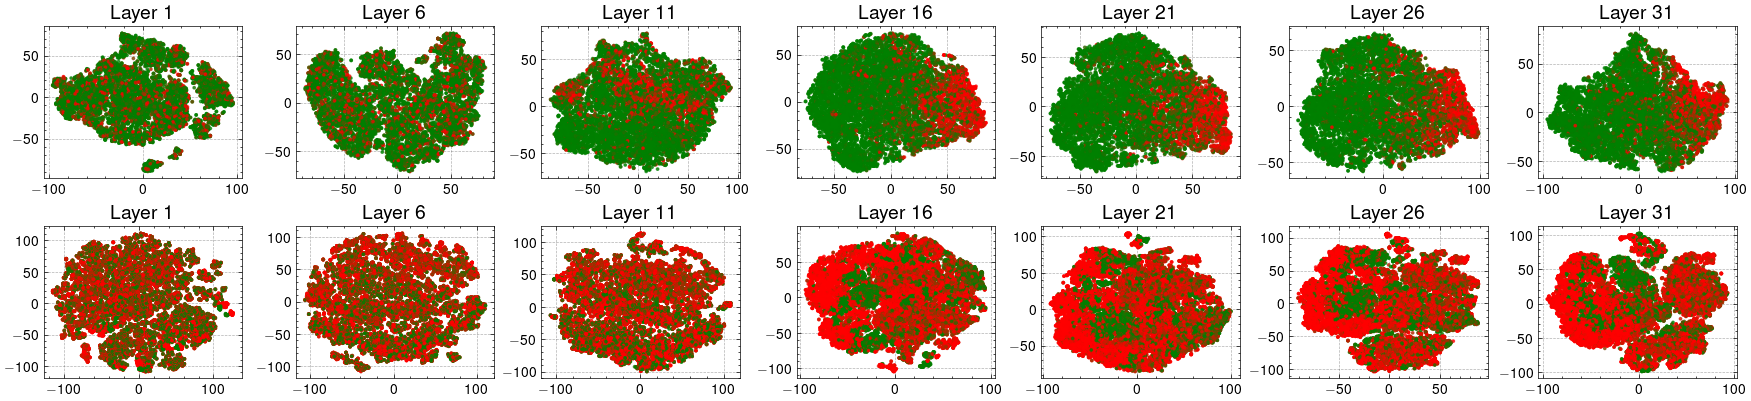

In [3]:
cmap = LinearSegmentedColormap.from_list("red_green", ["red", "green"], N=11)

fig, ax = plt.subplots(len(target_tasks), len(target_layers), figsize=(2.5 * len(target_layers), 2 * len(target_tasks)), constrained_layout=True)
for i, target_task in enumerate(tqdm(target_tasks, desc='tasks')):
    for j, target_layer in enumerate(tqdm(target_layers, desc='layers')):
        scatter = ax[i, j].scatter(df_vis[(target_task, target_layer)]["Component 1"], df_vis[(target_task, target_layer)]["Component 2"], c=df_vis[(target_task, target_layer)]["Test Score"], cmap=cmap, alpha=0.7, s=3)
        ax[i, j].grid(alpha=0.3)
        ax[i, j].set_title(f'Layer {target_layer}')

fig.show()
fig.savefig(f'./figures/exploratory/layer_tsne_{model}.png')
fig.savefig(f'./figures/exploratory/layer_tsne_{model}.pdf', dpi=300)